<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [2]:
# remove library not used
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from google.colab import drive
import os
from google.colab import files
from joblib import dump, load

In [3]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Read train set

In [4]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_season_vs_playoff_train.pkl?raw=true")
train_set

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,7.0,18.7,0.373,18.4,24.6,0.747,16.4,32.7,49.1,28.5,14.7,9.5,4.4,3.8,21.5,0.2,112.4,11.8,10,Chicago Bulls,38.5,88.4,0.436,6.3,18.7,0.335,17.3,23.5,0.737,14.5,29.3,43.8,21.5,17.2,8.3,3.8,4.4,23.0,21.5,100.7,1,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,9.0,25.1,0.360,20.4,26.8,0.763,14.0,32.2,46.2,21.3,16.8,9.6,5.8,4.5,21.8,0.1,106.4,6.1,10,Atlanta Hawks,38.4,88.3,0.435,6.6,19.2,0.347,16.9,22.9,0.737,14.3,30.4,44.8,22.8,17.3,8.3,4.5,5.8,23.9,21.8,100.3,0,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,82,40,42,0.488,52.1,38.7,84.8,0.456,4.9,14.4,0.339,21.6,28.7,0.751,12.6,30.3,42.9,24.7,16.4,8.1,7.3,5.9,24.0,0.2,103.9,-1.6,10,Minnesota Timberwolves,38.8,86.2,0.450,6.2,17.0,0.362,21.7,28.8,0.754,14.1,31.1,45.2,23.5,16.9,8.6,5.9,7.3,24.1,24.0,105.5,0,1996-97,1610612750199697
4,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,4.4,12.0,0.370,24.7,32.1,0.769,11.8,32.0,43.9,29.2,16.7,9.9,5.6,5.0,26.3,0.2,112.4,9.6,10,Utah Jazz,36.0,82.3,0.438,6.9,19.7,0.352,23.9,31.8,0.750,12.7,27.9,40.7,21.2,17.7,8.5,5.0,5.6,27.2,26.3,102.8,0,1996-97,1610612762199697
5,1610612761,Toronto Raptors,82,30,52,0.366,52.1,38.1,87.2,0.437,7.7,21.3,0.363,19.0,26.4,0.720,14.9,29.6,44.5,22.5,17.7,9.5,6.8,5.8,24.8,0.1,102.9,-3.4,10,Toronto Raptors,39.1,84.0,0.465,6.5,18.8,0.348,21.6,29.9,0.724,13.6,30.9,44.5,25.9,17.6,8.9,5.8,6.8,23.6,24.8,106.3,0,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,1610612742,Dallas Mavericks,82,52,30,0.634,50.2,40.9,88.7,0.461,13.6,38.9,0.350,17.0,22.1,0.771,9.6,35.2,44.8,24.4,13.0,7.0,4.1,3.8,20.5,20.9,112.5,3.4,10,Dallas Mavericks,40.6,88.9,0.457,11.4,33.5,0.340,16.5,21.5,0.767,9.9,35.6,45.5,24.5,13.6,7.3,3.8,4.1,20.9,20.5,109.1,0,2021-22,1610612742202122
767,1610612739,Cleveland Cavaliers,82,44,38,0.537,49.5,40.9,87.1,0.469,12.0,33.7,0.355,17.3,22.7,0.760,10.5,35.0,45.5,25.9,14.8,7.3,4.3,4.8,18.0,20.6,111.0,2.2,10,Cleveland Cavaliers,40.6,89.8,0.452,12.1,34.2,0.353,15.5,20.0,0.774,10.8,33.4,44.1,24.8,13.8,8.7,4.8,4.3,20.6,18.0,108.8,0,2021-22,1610612739202122
768,1610612741,Chicago Bulls,82,46,36,0.561,48.6,42.1,87.7,0.480,10.7,29.1,0.369,17.7,21.7,0.813,8.8,34.0,42.7,24.1,13.0,7.2,4.1,5.0,19.0,18.3,112.7,-0.4,10,Chicago Bulls,41.8,88.3,0.474,11.8,32.3,0.366,17.6,22.1,0.795,9.4,34.2,43.6,25.2,13.2,7.2,5.0,4.1,18.3,19.0,113.0,0,2021-22,1610612741202122
769,1610612766,Charlotte Hornets,82,43,39,0.524,47.8,42.2,90.1,0.468,13.7,37.6,0.365,15.6,21.1,0.740,10.7,33.2,43.9,27.7,13.1,8.5,4.8,4.5,19.6,19.3,113.6,0.4,10,Charlotte Hornets,41.4,88.8,0.466,13.8,38.1,0.362,16.6,21.8,0.763,11.2,35.1,46.3,26.1,14.8,7.4,4.5,4.8,19.3,19.6,113.2,0,2021-22,1610612766202122


# Exploratory data analysis
- dataset set can be split into left and right half
- left half = team stats
- right half = team stats (ranked)
- Y = PLAYOFF_RANKING

In [ ]:
pd.DataFrame(train_set.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category,category,object


In [ ]:
train_set.describe()

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.00000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,79.243112,39.291734,39.951378,0.496026,50.939222,39.34295,86.940681,0.452590,7.676013,21.578282,0.353887,19.093355,25.297731,0.755896,11.867585,32.967747,44.835170,23.273258,15.340194,8.073906,5.151053,5.187682,22.208428,14.027877,105.454457,-0.075203,39.372934,86.929498,0.452942,7.658671,21.500810,0.355178,19.125770,25.323177,0.755925,11.858509,32.994327,44.854133,23.310049,15.315883,8.107618,5.187682,5.151053,22.210859,22.208266,105.530794
std,7.231507,12.858842,12.953497,0.155499,1.998738,1.56598,2.095438,0.016397,2.815860,7.553241,0.021219,2.207375,3.088594,0.029930,1.760447,1.752766,1.850486,1.924681,1.425512,0.948144,0.891047,0.751413,2.257684,10.115921,4.390284,4.904257,1.696912,2.087199,0.015962,2.540802,6.886266,0.015414,2.227638,3.082222,0.016660,1.475865,1.723091,1.633364,1.675113,1.437217,0.793126,0.751413,0.891047,2.137709,2.257480,4.268511
min,50.000000,7.000000,9.000000,0.106000,45.500000,34.20000,80.400000,0.401000,2.100000,8.100000,0.264000,12.800000,17.400000,0.668000,7.700000,27.300000,37.800000,17.800000,11.200000,5.700000,2.400000,3.100000,16.800000,0.000000,91.200000,-15.100000,34.400000,79.600000,0.402000,3.700000,11.500000,0.300000,14.200000,18.200000,0.694000,8.300000,27.000000,39.900000,18.100000,11.500000,6.200000,3.100000,2.400000,17.500000,16.800000,93.000000
25%,82.000000,29.000000,30.000000,0.380000,49.500000,38.30000,85.600000,0.442000,5.600000,16.000000,0.341000,17.500000,22.900000,0.739000,10.600000,31.800000,43.600000,21.900000,14.300000,7.500000,4.500000,4.700000,20.500000,0.200000,102.700000,-3.400000,38.300000,85.700000,0.442000,5.700000,16.200000,0.345000,17.500000,23.000000,0.745000,10.800000,31.900000,43.700000,22.100000,14.300000,7.500000,4.700000,4.500000,20.600000,20.500000,102.600000
50%,82.000000,40.000000,39.000000,0.506000,51.200000,39.30000,87.000000,0.452000,7.200000,20.100000,0.354000,19.000000,25.300000,0.757000,11.800000,32.900000,44.800000,23.200000,15.300000,8.000000,5.100000,5.200000,22.100000,20.000000,105.100000,0.000000,39.500000,87.000000,0.454000,6.900000,19.500000,0.355000,18.900000,25.100000,0.756000,11.800000,33.000000,44.900000,23.400000,15.300000,8.100000,5.200000,5.100000,22.100000,22.100000,105.400000
75%,82.000000,49.000000,49.000000,0.610000,52.500000,40.40000,88.400000,0.464000,9.400000,26.200000,0.368000,20.500000,27.300000,0.776000,13.000000,34.200000,46.100000,24.400000,16.300000,8.700000,5.700000,5.700000,23.700000,21.700000,108.500000,3.400000,40.600000,88.300000,0.464000,9.100000,25.400000,0.365000,20.700000,27.600000,0.768000,13.000000,34.100000,46.000000,24.500000,16.300000,8.600000,5.700000,5.700000,23.700000,23.700000,108.700000
max,82.000000,73.000000,72.000000,0.890000,56.900000,43.70000,93.300000,0.504000,16.800000,45.800000,0.428000,27.400000,35.400000,0.839000,18.100000,39.800000,51.600000,30.100000,20.800000,12.000000,8.600000,7.400000,29.500000,28.400000,117.300000,11.800000,44.100000,93.200000,0.503000,14.600000,40.200000,0.406000,27.400000,35.800000,0.807000,16.200000,38.100000,51.000000,28.300000,20.300000,11.400000,7.400000,8.600000,29.200000,29.500000,116.600000


In [ ]:
# explanatory variable (Y) = PLAYOFF_RANKING
# for some seasons, we don't have a champion becuz of train-test split
train_set.groupby(["SEASON"]).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = "level_1", columns = "SEASON", values = "PLAYOFF_RANKING")

SEASON,1996-97,1997-98,1998-99,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,,,
0,24,23,23,22,23,25,21,23,24,21,22,23,20,21,23,23,21,23,26,24,23,22,23,24,25,24
1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1


In [ ]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

In [ ]:
numeric_col = train_set.columns[[x in train_set.select_dtypes(include=np.number).columns for x in train_set.columns]].tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 46


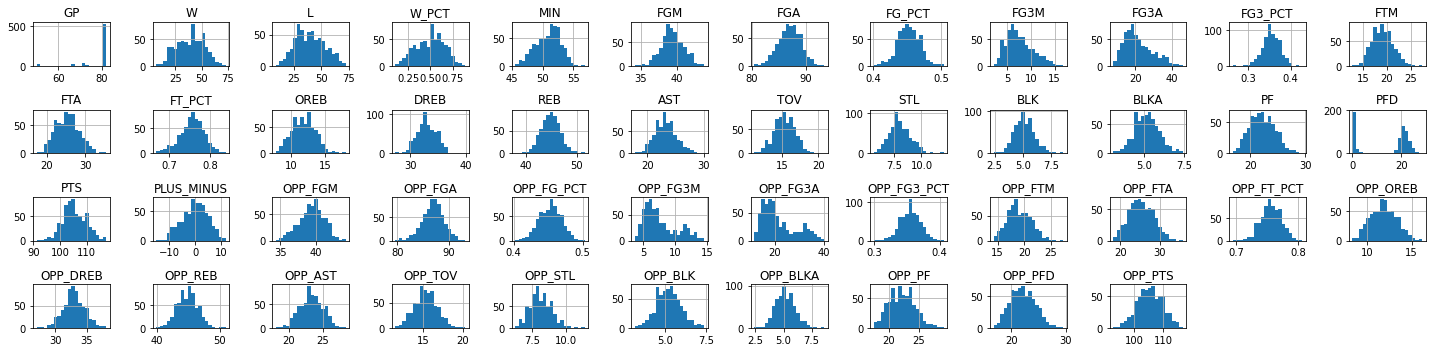

In [ ]:
# plot distributions of each numeric column
# rank of each variable will exhibit uniform distribution
train_set.hist(bins=20, layout = (4, int(len(numeric_col) / 4) + 1))
plt.tight_layout()
plt.show()

In [ ]:
# outlier: PFD (Personal Fouls Drawn) with a high frequency at 0 while OPP_PF (ie PFD) has a more even distribution
train_set.PFD.value_counts(bins = np.linspace(train_set.PFD.min(), train_set.PFD.max(), 10, dtype=int)).sort_index()

(-0.001, 3.0]    211
(3.0, 6.0]         4
(6.0, 9.0]         0
(9.0, 12.0]        0
(12.0, 15.0]       0
(15.0, 18.0]       9
(18.0, 22.0]     265
(22.0, 25.0]     116
(25.0, 28.0]      11
Name: PFD, dtype: int64

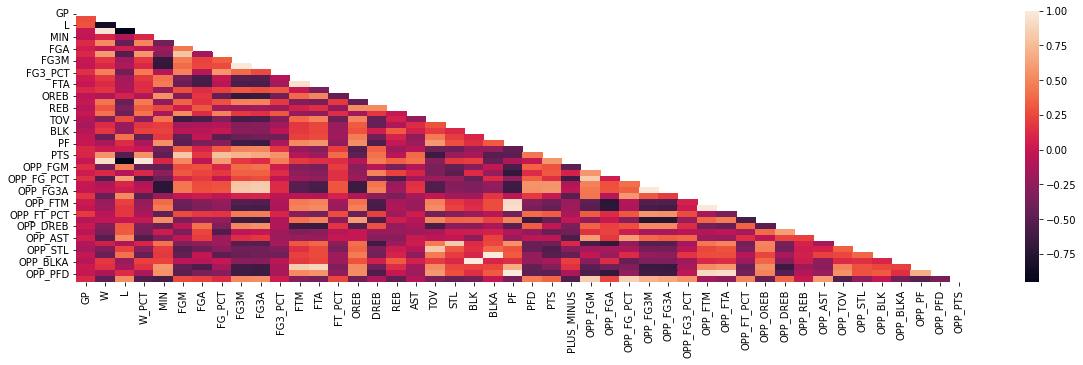

In [ ]:
# normal observations:
## positive correlation between Wins and Plus Minus (net of points scored and lost per 100 posessions)
## negative correlation between FGM, FGA vs defensive stats (STL, BLK, PF) -> perhaps more effort on defensive end means less energy available on offensive end

# interesting observations:
## negative correlation between OREB and (FG3M, FG3A, FG3%) but not so much with FG -> missing shots lead to more OREB and fewer attempts
## positive correlation between DREB and (FG3M, FG3A, FG3%) but not so much with FG -> opponents missing shots lead to more risk taking in shooting 3 instead of 2
corr_mat = train_set.loc[:,numeric_col].corr()
sns.heatmap(corr_mat, 
            annot=False, 
            mask = np.triu(corr_mat)) # to show only lower triangle
plt.show()

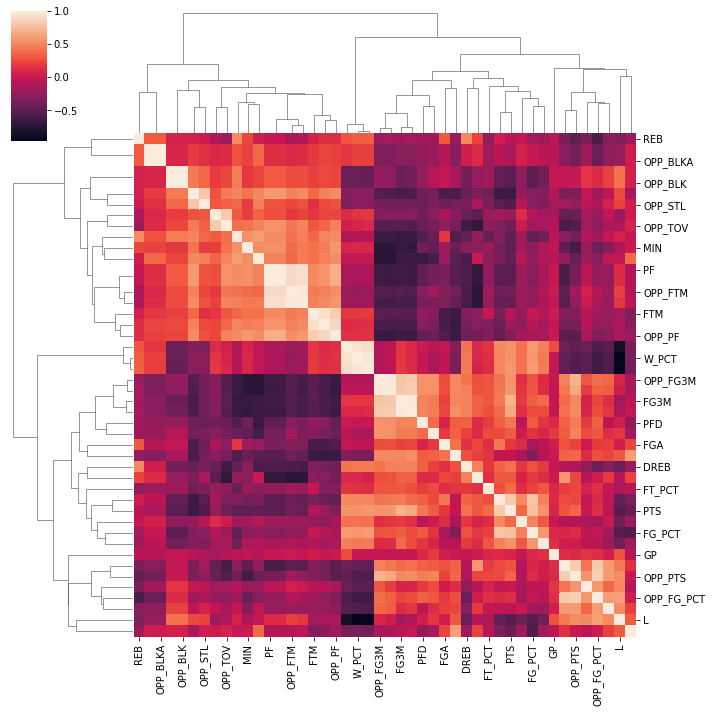

In [ ]:
# use dendrogram to see clusters
sns.clustermap(corr_mat)

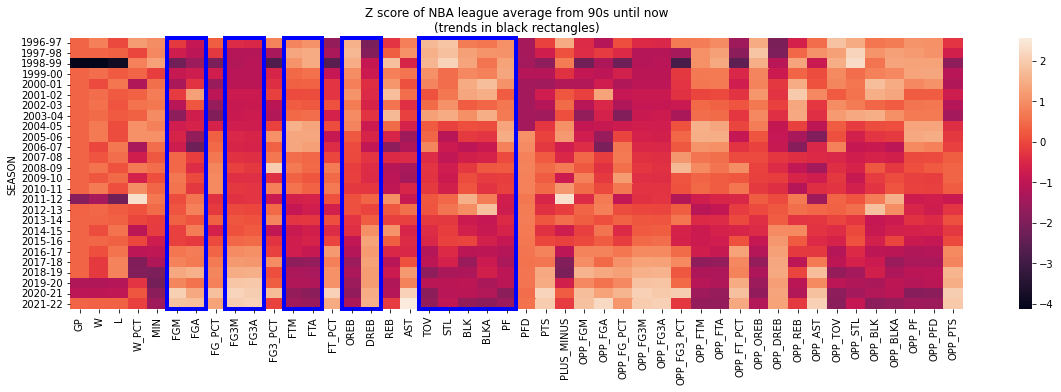

In [ ]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams play more defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: clustering for SEASON to take into account this difference 
ax = sns.heatmap(train_set.loc[:,numeric_col + ["SEASON"]].groupby("SEASON").mean().apply(zscore))
plt.title("Z score of NBA league average from 90s until now\n(trends in black rectangles)")
for col in [("FGM", "FGA"), ("FG3M", "FG3A"), ("FTM", "FTA"), ("OREB", "DREB"), ("TOV", "STL", "BLK", "BLKA", "PF")]:
  if len(col) > 1:
    ax.add_patch(Rectangle((numeric_col.index(col[0]), 0), len(col), len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
  else:
    ax.add_patch(Rectangle((numeric_col.index(col), 0), 1, len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
plt.show()

# check sklearn feature_selection

# Data preparation
- Over/Under-sampling to reduce imbalance in data
  - data set is highly imbalanced with only 1 out of 30 NBA teams winning the championship each year
  - however, over-sampling the champions may exacerbate the bias in our small sample
  - there is not enough data to under-sample as well
  - therefore let's keep it as is and use confusion matrix to measure performance accordingly
- Data cleaning
  - Fix PFD column with OPP_PF column
  - Drop irrelevant columns, e.g. GP (Games Played) is 82 for most seasons and stats are already normalized per 100 possessions
  - Feature scaling
    - Transform numeric variables by normal quantiles 
  
- Feature engineering
  - Cluster similar seasons together with KMeans to represent different NBA eras
  - Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
  - Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

- Dimensionality reduction
  - PCA to speed up random forest and fix axis orientation issue with decision tree

- Feature selection
  - Use random forest to drop useless features

In [5]:
# make a copy and split X and y
season = train_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
season_label = train_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [6]:
# X_train before data preparation
season

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,7.0,18.7,0.373,18.4,24.6,0.747,16.4,32.7,49.1,28.5,14.7,9.5,4.4,3.8,21.5,0.2,112.4,11.8,10,Chicago Bulls,38.5,88.4,0.436,6.3,18.7,0.335,17.3,23.5,0.737,14.5,29.3,43.8,21.5,17.2,8.3,3.8,4.4,23.0,21.5,100.7,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,9.0,25.1,0.360,20.4,26.8,0.763,14.0,32.2,46.2,21.3,16.8,9.6,5.8,4.5,21.8,0.1,106.4,6.1,10,Atlanta Hawks,38.4,88.3,0.435,6.6,19.2,0.347,16.9,22.9,0.737,14.3,30.4,44.8,22.8,17.3,8.3,4.5,5.8,23.9,21.8,100.3,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,82,40,42,0.488,52.1,38.7,84.8,0.456,4.9,14.4,0.339,21.6,28.7,0.751,12.6,30.3,42.9,24.7,16.4,8.1,7.3,5.9,24.0,0.2,103.9,-1.6,10,Minnesota Timberwolves,38.8,86.2,0.450,6.2,17.0,0.362,21.7,28.8,0.754,14.1,31.1,45.2,23.5,16.9,8.6,5.9,7.3,24.1,24.0,105.5,1996-97,1610612750199697
3,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,4.4,12.0,0.370,24.7,32.1,0.769,11.8,32.0,43.9,29.2,16.7,9.9,5.6,5.0,26.3,0.2,112.4,9.6,10,Utah Jazz,36.0,82.3,0.438,6.9,19.7,0.352,23.9,31.8,0.750,12.7,27.9,40.7,21.2,17.7,8.5,5.0,5.6,27.2,26.3,102.8,1996-97,1610612762199697
4,1610612761,Toronto Raptors,82,30,52,0.366,52.1,38.1,87.2,0.437,7.7,21.3,0.363,19.0,26.4,0.720,14.9,29.6,44.5,22.5,17.7,9.5,6.8,5.8,24.8,0.1,102.9,-3.4,10,Toronto Raptors,39.1,84.0,0.465,6.5,18.8,0.348,21.6,29.9,0.724,13.6,30.9,44.5,25.9,17.6,8.9,5.8,6.8,23.6,24.8,106.3,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1610612742,Dallas Mavericks,82,52,30,0.634,50.2,40.9,88.7,0.461,13.6,38.9,0.350,17.0,22.1,0.771,9.6,35.2,44.8,24.4,13.0,7.0,4.1,3.8,20.5,20.9,112.5,3.4,10,Dallas Mavericks,40.6,88.9,0.457,11.4,33.5,0.340,16.5,21.5,0.767,9.9,35.6,45.5,24.5,13.6,7.3,3.8,4.1,20.9,20.5,109.1,2021-22,1610612742202122
613,1610612739,Cleveland Cavaliers,82,44,38,0.537,49.5,40.9,87.1,0.469,12.0,33.7,0.355,17.3,22.7,0.760,10.5,35.0,45.5,25.9,14.8,7.3,4.3,4.8,18.0,20.6,111.0,2.2,10,Cleveland Cavaliers,40.6,89.8,0.452,12.1,34.2,0.353,15.5,20.0,0.774,10.8,33.4,44.1,24.8,13.8,8.7,4.8,4.3,20.6,18.0,108.8,2021-22,1610612739202122
614,1610612741,Chicago Bulls,82,46,36,0.561,48.6,42.1,87.7,0.480,10.7,29.1,0.369,17.7,21.7,0.813,8.8,34.0,42.7,24.1,13.0,7.2,4.1,5.0,19.0,18.3,112.7,-0.4,10,Chicago Bulls,41.8,88.3,0.474,11.8,32.3,0.366,17.6,22.1,0.795,9.4,34.2,43.6,25.2,13.2,7.2,5.0,4.1,18.3,19.0,113.0,2021-22,1610612741202122
615,1610612766,Charlotte Hornets,82,43,39,0.524,47.8,42.2,90.1,0.468,13.7,37.6,0.365,15.6,21.1,0.740,10.7,33.2,43.9,27.7,13.1,8.5,4.8,4.5,19.6,19.3,113.6,0.4,10,Charlotte Hornets,41.4,88.8,0.466,13.8,38.1,0.362,16.6,21.8,0.763,11.2,35.1,46.3,26.1,14.8,7.4,4.5,4.8,19.3,19.6,113.2,2021-22,1610612766202122


In [7]:
# y_train before data preparation
season_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Feature engineering - NewColumn
- Before data cleaning
- Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
- Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

In [8]:
# create a custom transformer to perform numerical operations on columns 
# FunctionTransformer cannot be used in pipeline since it does not return the whole dataframe + the new columns
class NewColumn(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
    output = copy.deepcopy(X)
    output['FG2A'] = output['FGA'] - output['FG3A']
    # 2 Point Field Goals Made
    output['FG2M'] = output['FGM'] - output['FG3M']
    # Percentage of 2 Point Field Goals Made
    output['FG2_PCT'] = output['FG2M'] / output['FG2A']
    # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
    output['FG2_FG3'] = output['FG2A'] / output['FG3A']
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [9]:
NewColumn().fit_transform(season)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,SEASON,UNIQUE_ID,FG2A,FG2M,FG2_PCT,FG2_FG3
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,7.0,18.7,0.373,18.4,24.6,0.747,16.4,32.7,49.1,28.5,14.7,9.5,4.4,3.8,21.5,0.2,112.4,11.8,10,Chicago Bulls,38.5,88.4,0.436,6.3,18.7,0.335,17.3,23.5,0.737,14.5,29.3,43.8,21.5,17.2,8.3,3.8,4.4,23.0,21.5,100.7,1996-97,1610612741199697,73.3,36.6,0.499318,3.919786
1,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,9.0,25.1,0.360,20.4,26.8,0.763,14.0,32.2,46.2,21.3,16.8,9.6,5.8,4.5,21.8,0.1,106.4,6.1,10,Atlanta Hawks,38.4,88.3,0.435,6.6,19.2,0.347,16.9,22.9,0.737,14.3,30.4,44.8,22.8,17.3,8.3,4.5,5.8,23.9,21.8,100.3,1996-97,1610612737199697,61.2,29.5,0.482026,2.438247
2,1610612750,Minnesota Timberwolves,82,40,42,0.488,52.1,38.7,84.8,0.456,4.9,14.4,0.339,21.6,28.7,0.751,12.6,30.3,42.9,24.7,16.4,8.1,7.3,5.9,24.0,0.2,103.9,-1.6,10,Minnesota Timberwolves,38.8,86.2,0.450,6.2,17.0,0.362,21.7,28.8,0.754,14.1,31.1,45.2,23.5,16.9,8.6,5.9,7.3,24.1,24.0,105.5,1996-97,1610612750199697,70.4,33.8,0.480114,4.888889
3,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,4.4,12.0,0.370,24.7,32.1,0.769,11.8,32.0,43.9,29.2,16.7,9.9,5.6,5.0,26.3,0.2,112.4,9.6,10,Utah Jazz,36.0,82.3,0.438,6.9,19.7,0.352,23.9,31.8,0.750,12.7,27.9,40.7,21.2,17.7,8.5,5.0,5.6,27.2,26.3,102.8,1996-97,1610612762199697,70.7,37.2,0.526167,5.891667
4,1610612761,Toronto Raptors,82,30,52,0.366,52.1,38.1,87.2,0.437,7.7,21.3,0.363,19.0,26.4,0.720,14.9,29.6,44.5,22.5,17.7,9.5,6.8,5.8,24.8,0.1,102.9,-3.4,10,Toronto Raptors,39.1,84.0,0.465,6.5,18.8,0.348,21.6,29.9,0.724,13.6,30.9,44.5,25.9,17.6,8.9,5.8,6.8,23.6,24.8,106.3,1996-97,1610612761199697,65.9,30.4,0.461305,3.093897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1610612742,Dallas Mavericks,82,52,30,0.634,50.2,40.9,88.7,0.461,13.6,38.9,0.350,17.0,22.1,0.771,9.6,35.2,44.8,24.4,13.0,7.0,4.1,3.8,20.5,20.9,112.5,3.4,10,Dallas Mavericks,40.6,88.9,0.457,11.4,33.5,0.340,16.5,21.5,0.767,9.9,35.6,45.5,24.5,13.6,7.3,3.8,4.1,20.9,20.5,109.1,2021-22,1610612742202122,49.8,27.3,0.548193,1.280206
613,1610612739,Cleveland Cavaliers,82,44,38,0.537,49.5,40.9,87.1,0.469,12.0,33.7,0.355,17.3,22.7,0.760,10.5,35.0,45.5,25.9,14.8,7.3,4.3,4.8,18.0,20.6,111.0,2.2,10,Cleveland Cavaliers,40.6,89.8,0.452,12.1,34.2,0.353,15.5,20.0,0.774,10.8,33.4,44.1,24.8,13.8,8.7,4.8,4.3,20.6,18.0,108.8,2021-22,1610612739202122,53.4,28.9,0.541199,1.584570
614,1610612741,Chicago Bulls,82,46,36,0.561,48.6,42.1,87.7,0.480,10.7,29.1,0.369,17.7,21.7,0.813,8.8,34.0,42.7,24.1,13.0,7.2,4.1,5.0,19.0,18.3,112.7,-0.4,10,Chicago Bulls,41.8,88.3,0.474,11.8,32.3,0.366,17.6,22.1,0.795,9.4,34.2,43.6,25.2,13.2,7.2,5.0,4.1,18.3,19.0,113.0,2021-22,1610612741202122,58.6,31.4,0.535836,2.013746
615,1610612766,Charlotte Hornets,82,43,39,0.524,47.8,42.2,90.1,0.468,13.7,37.6,0.365,15.6,21.1,0.740,10.7,33.2,43.9,27.7,13.1,8.5,4.8,4.5,19.6,19.3,113.6,0.4,10,Charlotte Hornets,41.4,88.8,0.466,13.8,38.1,0.362,16.6,21.8,0.763,11.2,35.1,46.3,26.1,14.8,7.4,4.5,4.8,19.3,19.6,113.2,2021-22,1610612766202122,52.5,28.5,0.542857,1.396277


## Feature scaling - num_pipeline
- Custom transformers to fix and drop columns
- Scale numeric features by normal quantiles

In [10]:
# # create a custom transformer to remove outliers with Isolation Forest
# class OutlierRemover(BaseEstimator, TransformerMixin):
#   def __init__(self, random_state = None):
#     self.random_state = random_state
  
#   def fit(self, X, y = None, sample_weight = None):
#     self.X_ = X
#     return self
  
#   def transform(self, X):
#     # self.feature_names_in_ = X_season.columns
#     # self.index_names = X_season.sort_index().index.values
#     print(X.shape)
#     print(type(X))
#     self.isolationforest_ = IsolationForest(random_state=self.random_state)
#     outliers = self.isolationforest_.fit_predict(X)
#     print(outliers)
#     return X.iloc[outliers != -1].reset_index(drop = True)
  
#   def get_feature_names_out(self):
#     return self.X_.columns.values

In [11]:
# create a custom transformer to fix PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

In [12]:
num_pipeline = make_pipeline(
    # replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD", "OPP_PF"),
    # drop irrelevant / duplicate columns
    DropCols(["GP", "MIN", "OPP_PF", "OPP_PFD"]),
    # feature scaling + outlier removal by transforming features into quantiles
      # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
      # instead of taking log for every feature
    MyQuantileTransformer(output_distribution="normal", random_state=42)
)

In [13]:
pd.DataFrame(num_pipeline.fit_transform(season.select_dtypes(include=np.number)),
             columns = num_pipeline.get_feature_names_out())

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS
0,2.943356,-2.721761,2.943356,2.721761,2.584916,1.296494,-0.057000,-0.229884,0.899274,-0.278219,-0.229884,-0.361759,2.336206,-0.103952,2.138607,2.584916,-0.425524,1.441829,-0.848600,-1.904707,-0.269769,0.346594,1.534121,5.199338,-0.573127,0.737137,-1.025357,-0.288809,-0.122381,-1.355292,-0.758667,-0.523467,-1.142499,1.802743,-2.202962,-0.634164,-1.011686,1.301224,0.276105,-1.904707,-0.848600,-1.127005
1,1.305983,-1.042720,1.207414,-0.561179,-0.355250,-0.407771,0.537519,0.556422,0.299432,0.624244,0.511835,0.190361,1.215892,-0.416631,0.750552,-1.053291,1.025357,1.603763,0.739810,-0.962021,-0.108044,0.800016,0.299432,1.268707,-0.626718,0.674490,-1.111778,-0.161432,-0.038667,-0.551678,-1.028805,-0.726500,-1.142499,1.626252,-1.459307,-0.059038,-0.310089,1.370745,0.276105,-0.962021,0.739810,-1.241867
2,-0.024418,0.227796,-0.136743,-0.392342,-1.001555,0.215285,-1.008297,-0.988206,-0.805633,1.093098,1.093098,-0.238249,0.394541,-1.547456,-1.004921,0.828358,0.750552,0.083516,2.251551,0.991526,0.791639,0.878136,-0.314361,-0.368283,-0.403353,-0.425524,-0.242437,-0.355250,-0.504890,0.418851,1.115560,1.082071,-0.122381,1.501923,-1.100524,0.213203,0.077392,1.085732,0.639147,0.991526,2.251551,0.028488
3,2.100165,-1.904707,2.100165,1.345167,-1.957194,5.199338,-1.207414,-1.483329,0.755956,2.584916,2.159077,0.412197,-0.012208,-0.535170,-0.544585,2.943356,0.949173,1.845705,0.539871,-0.236156,1.753330,2.138607,1.534121,2.336206,-1.823803,-2.031466,-0.911536,-0.002035,0.052924,-0.240342,2.064598,2.015702,-0.374823,0.530480,-2.943356,-2.647169,-1.203207,1.633934,0.514156,-0.236156,0.539871,-0.602145
4,-0.646652,0.842782,-0.734470,-0.828358,0.114185,-1.008297,0.177945,0.167619,0.427753,-0.002035,0.368283,-1.215892,1.802743,-2.064598,-0.194507,-0.374823,1.633934,1.441829,1.734710,0.887147,1.074793,0.621773,-0.587574,-0.684742,-0.211122,-1.408136,0.718575,-0.204885,-0.108044,-0.488776,1.063980,1.447606,-1.943564,1.142499,-1.211642,-0.227796,1.582058,1.561073,1.035737,0.887147,1.734710,0.169683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.917719,-0.666847,0.816943,0.971762,0.819787,0.523467,1.834644,2.082053,-0.246630,-0.942808,-1.001555,0.495666,-1.255174,1.233116,0.016278,0.674490,-1.603763,-1.146415,-1.264171,-1.904707,-0.682173,-0.530480,1.589210,0.666847,0.682173,0.991526,0.225708,1.074793,1.397252,-1.011686,-1.211642,-1.277860,0.634164,-1.282477,1.514614,0.390146,0.661773,-1.150349,-1.018498,-1.904707,-1.264171,0.772303
613,0.299432,-0.095772,0.171747,0.971762,0.065153,1.035737,1.330233,1.315590,0.048850,-0.766831,-0.755956,0.110090,-0.723853,1.082071,0.379192,1.340155,-0.357418,-0.802821,-0.975030,-0.518806,-2.138607,-0.671938,1.228776,0.377006,0.682173,1.424780,-0.124431,1.430417,1.527554,-0.165556,-1.725621,-1.792506,1.096804,-0.644146,0.305822,-0.416631,0.839883,-1.021921,0.761383,-0.518806,-0.975030,0.687317
614,0.441169,-0.231974,0.325068,1.782453,0.318639,1.699178,0.978308,0.908458,0.726500,-0.570731,-1.166267,2.000424,-1.880317,0.554049,-1.146415,0.504890,-1.603763,-0.911536,-1.264171,-0.236156,-1.441829,-1.985599,1.626252,-0.097817,1.527554,0.674490,1.381232,1.264171,1.119359,0.739810,-0.599707,-1.018498,2.441895,-1.753330,0.708079,-0.739810,1.032265,-1.402673,-1.166267,-0.236156,-1.264171,1.762872
615,0.231974,-0.028488,0.108044,1.917340,1.596444,0.945986,1.904707,1.904707,0.549311,-1.753330,-1.408136,-0.621773,-0.592417,0.163494,-0.544585,2.138607,-1.521052,0.479626,-0.353083,-0.962021,-1.150349,-1.391872,1.823803,0.065153,1.170293,0.939639,0.775047,2.368567,2.368567,0.418851,-1.170293,-1.162260,0.414413,-0.443412,1.259660,0.872168,1.72

## Combine as data_cleaning pipeline
- before performing clustering

In [14]:
data_cleaning = make_pipeline(
    # create new columns for FG2A, FG2M, FG2_PCT, FG2_FG3
    NewColumn(),
    ColumnTransformer([
        # fixing and scaling numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        # keep the SEASON column for clustering
        ("season", "passthrough", ["SEASON"])
      ], 
      # drop remaining identifier columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    )
)

In [15]:
pd.DataFrame(data_cleaning.fit_transform(season),
             columns = data_cleaning.get_feature_names_out())

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS,FG2A,FG2M,FG2_PCT,FG2_FG3,SEASON
0,2.943356,-2.721761,2.943356,2.721761,2.584916,1.296494,-0.057,-0.229884,0.899274,-0.278219,-0.229884,-0.361759,2.336206,-0.103952,2.138607,2.584916,-0.425524,1.441829,-0.8486,-1.904707,-0.269769,0.346594,1.534121,5.199338,-0.573127,0.737137,-1.025357,-0.288809,-0.122381,-1.355292,-0.758667,-0.523467,-1.142499,1.802743,-2.202962,-0.634164,-1.011686,1.301224,0.276105,-1.904707,-0.8486,-1.127005,1.178402,2.031466,0.580336,0.383568,1996-97
1,1.305983,-1.04272,1.207414,-0.561179,-0.35525,-0.407771,0.537519,0.556422,0.299432,0.624244,0.511835,0.190361,1.215892,-0.416631,0.750552,-1.053291,1.025357,1.603763,0.73981,-0.962021,-0.108044,0.800016,0.299432,1.268707,-0.626718,0.67449,-1.111778,-0.161432,-0.038667,-0.551678,-1.028805,-0.7265,-1.142499,1.626252,-1.459307,-0.059038,-0.310089,1.370745,0.276105,-0.962021,0.73981,-1.241867,-0.646652,-0.881131,-0.016278,-0.589994,1996-97
2,-0.024418,0.227796,-0.136743,-0.392342,-1.001555,0.215285,-1.008297,-0.988206,-0.805633,1.093098,1.093098,-0.238249,0.394541,-1.547456,-1.004921,0.828358,0.750552,0.083516,2.251551,0.991526,0.791639,0.878136,-0.314361,-0.368283,-0.403353,-0.425524,-0.242437,-0.35525,-0.50489,0.418851,1.11556,1.082071,-0.122381,1.501923,-1.100524,0.213203,0.077392,1.085732,0.639147,0.991526,2.251551,0.028488,0.616844,0.85152,-0.118282,0.914623,1996-97
3,2.100165,-1.904707,2.100165,1.345167,-1.957194,5.199338,-1.207414,-1.483329,0.755956,2.584916,2.159077,0.412197,-0.012208,-0.53517,-0.544585,2.943356,0.949173,1.845705,0.539871,-0.236156,1.75333,2.138607,1.534121,2.336206,-1.823803,-2.031466,-0.911536,-0.002035,0.052924,-0.240342,2.064598,2.015702,-0.374823,0.53048,-2.943356,-2.647169,-1.203207,1.633934,0.514156,-0.236156,0.539871,-0.602145,0.664308,2.584916,1.250714,1.365557,1996-97
4,-0.646652,0.842782,-0.73447,-0.828358,0.114185,-1.008297,0.177945,0.167619,0.427753,-0.002035,0.368283,-1.215892,1.802743,-2.064598,-0.194507,-0.374823,1.633934,1.441829,1.73471,0.887147,1.074793,0.621773,-0.587574,-0.684742,-0.211122,-1.408136,0.718575,-0.204885,-0.108044,-0.488776,1.06398,1.447606,-1.943564,1.142499,-1.211642,-0.227796,1.582058,1.561073,1.035737,0.887147,1.73471,0.169683,-0.089642,-0.592417,-0.958794,-0.163494,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.917719,-0.666847,0.816943,0.971762,0.819787,0.523467,1.834644,2.082053,-0.24663,-0.942808,-1.001555,0.495666,-1.255174,1.233116,0.016278,0.67449,-1.603763,-1.146415,-1.264171,-1.904707,-0.682173,-0.53048,1.58921,0.666847,0.682173,0.991526,0.225708,1.074793,1.397252,-1.011686,-1.211642,-1.27786,0.634164,-1.282477,1.514614,0.390146,0.661773,-1.150349,-1.018498,-1.904707,-1.264171,0.772303,-1.943564,-1.527554,1.868529,-2.031466,2021-22
613,0.299432,-0.095772,0.171747,0.971762,0.065153,1.035737,1.330233,1.31559,0.04885,-0.766831,-0.755956,0.11009,-0.723853,1.082071,0.379192,1.340155,-0.357418,-0.802821,-0.97503,-0.518806,-2.138607,-0.671938,1.228776,0.377006,0.682173,1.42478,-0.124431,1.430417,1.527554,-0.165556,-1.725621,-1.792506,1.096804,-0.644146,0.305822,-0.416631,0.839883,-1.021921,0.761383,-0.518806,-0.97503,0.687317,-1.408136,-1.093098,1.641714,-1.375969,2021-22
614,0.441169,-0.231974,0.325068,1.782453,0.318639,1.699178,0.978308,0.908458,0.7265,-0.570731,-1.166267,2.000424,-1.880317,0.554049,-1.146415,0.50489,-1.603763,-0.911536,-1.264171,-0.236156,-1.441829,-1.985599,1.626252,-0.097817,1.527554,0.67449,1.381232,1.264171,1.119359,0.73981,-0.599707,-1.018498,2.441895,-1.75333,0.708079,-0.73981,1.032265,-1.402673,-1.166267,-0.236156,-1.264171,1.762872,-0.857382,-0.

## Custom transformer - SeasonSimilarity
- After feature scaling (need to include in fit and transform methods of custom transformer instead of a step in pipeline object since we need the X as df instead of np array to group by SEASON
- Use silhouette score to measure performance of clustering
- Perform soft clustering on SEASON with KMeans to differentiate NBA eras

In [16]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None):
    self.n_clusters = n_clusters
    self.random_state = random_state
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    # pass the df into data_cleaning pipeline to scale features
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    # group by season to get league average
    X_season = X.groupby("SEASON").mean().sort_index().dropna(axis=0) # dropna as GridSearchCV will create NA for those seasons not included in CV folds
    self.feature_names_in_ = X.columns.values
    self.index_names = X_season.sort_index().index.values
    
    # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
    # don't consider tuning k as hyperparameter because silhouette score is more intuitive
    # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
    k_range = np.arange(2,11,1)
    silh_scores = []
    for k in range(2,11):
      self.n_clusters = k
      self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
      self.kmeans_.fit(X_season, sample_weight=sample_weight)
      silh_scores.append(silhouette_score(X_season, self.kmeans_.labels_))
    
    max_k = k_range[np.argmax(silh_scores)]
    max_silh = max(silh_scores)
    if plot_silh:
      plt.plot(k_range, silh_scores)
      plt.xlabel("Number of clusters")
      plt.ylabel("Silhouette score")
      plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
      plt.show()
    
    self.n_clusters = max_k
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X_season, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # pass the df into data_cleaning pipeline to scale features before clustering
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    
    X_season = X.groupby("SEASON").mean().sort_index()
    # soft clustering for n clusters + quantile transform = normalized cluster distance
    X_clusterdist = MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(self.kmeans_.transform(X_season))
    # X_clusterdist = self.kmeans_.transform(X_season)
    X_cluster = pd.DataFrame(X_clusterdist, index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
    output = X.merge(X_cluster, how = "inner", on = "SEASON")
    output.drop(columns = ["SEASON"], inplace = True)
    output.index = X[["SEASON"]]
    self.output_features = output.columns.values
    
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

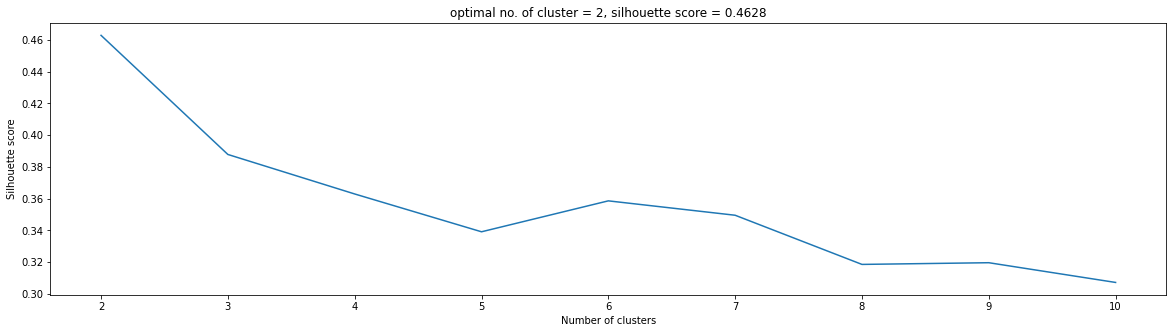

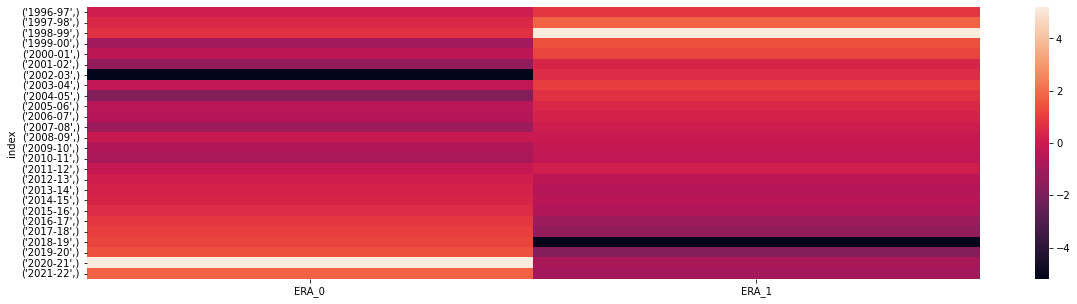

In [17]:
season_prepared = SeasonSimilarity(random_state=42).fit_transform(season, plot_silh = True)
sns.heatmap(season_prepared.loc[:, ["ERA" in x for x in season_prepared.columns]].reset_index().groupby(["index"]).mean())

### Alternative: agglomerative clustering

In [18]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [19]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(season)
# agg_cluster.plot_dendrogram()

## combine as data_preparation pipeline

In [20]:
# right now only 1 step because we need to incorporate data_cleaning pipeline into SeasonSimilarity 
# but we can add other steps later as well
data_preparation = make_pipeline(
    SeasonSimilarity(random_state=42)
)

data_preparation.fit_transform(season)

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS,FG2A,FG2M,FG2_PCT,FG2_FG3,ERA_0,ERA_1
"(1996-97,)",2.943356,-2.721761,2.943356,2.721761,2.584916,1.296494,-0.057,-0.229884,0.899274,-0.278219,-0.229884,-0.361759,2.336206,-0.103952,2.138607,2.584916,-0.425524,1.441829,-0.8486,-1.904707,-0.269769,0.346594,1.534121,5.199338,-0.573127,0.737137,-1.025357,-0.288809,-0.122381,-1.355292,-0.758667,-0.523467,-1.142499,1.802743,-2.202962,-0.634164,-1.011686,1.301224,0.276105,-1.904707,-0.8486,-1.127005,1.178402,2.031466,0.580336,0.383568,0.050154,0.841621
"(1996-97,)",1.305983,-1.04272,1.207414,-0.561179,-0.35525,-0.407771,0.537519,0.556422,0.299432,0.624244,0.511835,0.190361,1.215892,-0.416631,0.750552,-1.053291,1.025357,1.603763,0.73981,-0.962021,-0.108044,0.800016,0.299432,1.268707,-0.626718,0.67449,-1.111778,-0.161432,-0.038667,-0.551678,-1.028805,-0.7265,-1.142499,1.626252,-1.459307,-0.059038,-0.310089,1.370745,0.276105,-0.962021,0.73981,-1.241867,-0.646652,-0.881131,-0.016278,-0.589994,0.050154,0.841621
"(1996-97,)",-0.024418,0.227796,-0.136743,-0.392342,-1.001555,0.215285,-1.008297,-0.988206,-0.805633,1.093098,1.093098,-0.238249,0.394541,-1.547456,-1.004921,0.828358,0.750552,0.083516,2.251551,0.991526,0.791639,0.878136,-0.314361,-0.368283,-0.403353,-0.425524,-0.242437,-0.35525,-0.50489,0.418851,1.11556,1.082071,-0.122381,1.501923,-1.100524,0.213203,0.077392,1.085732,0.639147,0.991526,2.251551,0.028488,0.616844,0.85152,-0.118282,0.914623,0.050154,0.841621
"(1996-97,)",2.100165,-1.904707,2.100165,1.345167,-1.957194,5.199338,-1.207414,-1.483329,0.755956,2.584916,2.159077,0.412197,-0.012208,-0.53517,-0.544585,2.943356,0.949173,1.845705,0.539871,-0.236156,1.75333,2.138607,1.534121,2.336206,-1.823803,-2.031466,-0.911536,-0.002035,0.052924,-0.240342,2.064598,2.015702,-0.374823,0.53048,-2.943356,-2.647169,-1.203207,1.633934,0.514156,-0.236156,0.539871,-0.602145,0.664308,2.584916,1.250714,1.365557,0.050154,0.841621
"(1996-97,)",-0.646652,0.842782,-0.73447,-0.828358,0.114185,-1.008297,0.177945,0.167619,0.427753,-0.002035,0.368283,-1.215892,1.802743,-2.064598,-0.194507,-0.374823,1.633934,1.441829,1.73471,0.887147,1.074793,0.621773,-0.587574,-0.684742,-0.211122,-1.408136,0.718575,-0.204885,-0.108044,-0.488776,1.06398,1.447606,-1.943564,1.142499,-1.211642,-0.227796,1.582058,1.561073,1.035737,0.887147,1.73471,0.169683,-0.089642,-0.592417,-0.958794,-0.163494,0.050154,0.841621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2021-22,)",0.917719,-0.666847,0.816943,0.971762,0.819787,0.523467,1.834644,2.082053,-0.24663,-0.942808,-1.001555,0.495666,-1.255174,1.233116,0.016278,0.67449,-1.603763,-1.146415,-1.264171,-1.904707,-0.682173,-0.53048,1.58921,0.666847,0.682173,0.991526,0.225708,1.074793,1.397252,-1.011686,-1.211642,-1.27786,0.634164,-1.282477,1.514614,0.390146,0.661773,-1.150349,-1.018498,-1.904707,-1.264171,0.772303,-1.943564,-1.527554,1.868529,-2.031466,1.750686,-0.994458
"(2021-22,)",0.299432,-0.095772,0.171747,0.971762,0.065153,1.035737,1.330233,1.31559,0.04885,-0.766831,-0.755956,0.11009,-0.723853,1.082071,0.379192,1.340155,-0.357418,-0.802821,-0.97503,-0.518806,-2.138607,-0.671938,1.228776,0.377006,0.682173,1.42478,-0.124431,1.430417,1.527554,-0.165556,-1.725621,-1.792506,1.096804,-0.644146,0.305822,-0.416631,0.839883,-1.021921,0.761383,-0.518806,-0.97503,0.687317,-1.408136,-1.093098,1.641714,-1.375969,1.750686,-0.994458
"(2021-22,)",0.441169,-0.231974,0.325068,1.782453,0.318639,1.699178,0.978308,0.908458,0.7265,-0.570731,-1.166267,2.000424,-1.880317,0.554049,-1.146415,0.50489,-1.603763,-0.911536,-1.264171,-0.236156,-1.441829,-1.985599,1.626252,-0.097817,1.527554,0.67449

## (optional) Dimensionality reduction
- advantage
  - PCA can solve the axis orientation issue with decision tree
- disadvantage
  - information loss
  - harder to maintain pipeline as new data comes in
    - assume the current dataset is a random sampling of the underlying population, the PCA components should be stable
- considerations
  - let's not use PCA to allow interpretation of our feature
  - if we need to use decision tree, we can still use random forests or other ensemble methods on top of it
  - but random forest still assign high feature importance to highly correlated features (e.g. W_PCT, W, L)

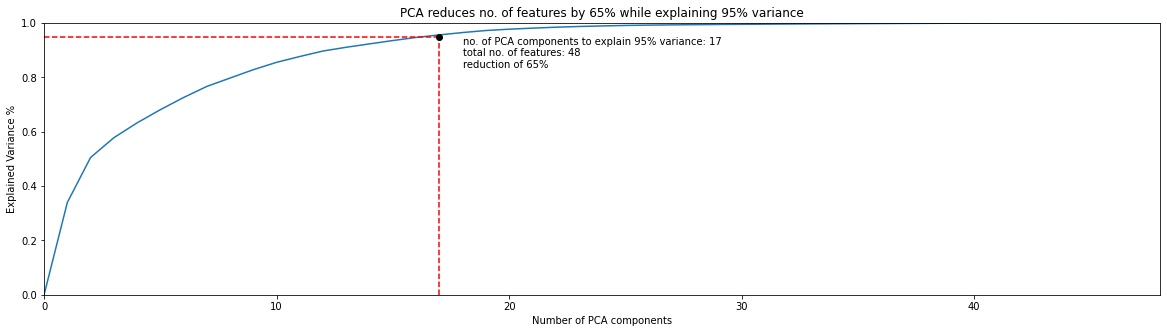

In [21]:
pca = PCA().fit(season_prepared)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
# aim for 95% variance explained
target = np.argmax(pca_cumsum >= 0.95) + 1 # python starts counting at 0
plt.plot([*range(0,len(pca_cumsum)+1)], [0, *pca_cumsum])
plt.xlim(0,len(pca_cumsum))
plt.ylim(0,1)
plt.xlabel("Number of PCA components")
plt.ylabel("Explained Variance %")
plt.plot([target, target], [0, 0.95], 'r--')
plt.plot([0, target], [0.95, 0.95], 'r--')
plt.plot(target, 0.95, 'ko')
plt.annotate(f"no. of PCA components to explain 95% variance: {target}\n" + 
             f"total no. of features: {pca.n_features_in_}\n" + 
             f"reduction of {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%}", 
             [target+1, 0.95],
             ha = 'left',
             va = 'top')
plt.title(f"PCA reduces no. of features by {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%} while explaining 95% variance")
plt.show()

In [22]:
# don't add to data_preparation pipeline
# while PCA can help reduce no. of features significantly, reduce training time and avoid axis orientation issues in decision tree, 
# I want to keep features interpretable given the dataset is not too large

# data_preparation.steps.append(
#     ("pca", PCA(n_components=0.95))
# )

In [23]:
# print(f"target no. of features to explain 95% variance = {data_preparation.fit_transform(season).shape[1]}")

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [24]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
    threshold=None # hyperparameter to tune
    ).fit(season_prepared, season_label.reshape(-1,))

In [25]:
# hyperparameter to tune
selector.threshold_

1e-05

In [26]:
# original training set
season.shape

(617, 52)

In [27]:
# reduced no. of features
selector.transform(season_prepared).shape

(617, 22)

In [28]:
# columns dropped
data_preparation.get_feature_names_out()[~selector.get_support()]

array(['L', 'W_PCT', 'FGA', 'FG_PCT', 'FG3M', 'FTA', 'OREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'PFD', 'PTS', 'OPP_FGM', 'OPP_FG3M',
       'OPP_FG3A', 'OPP_FTM', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_TOV',
       'OPP_BLKA', 'OPP_PTS', 'FG2A', 'FG2M', 'FG2_FG3'], dtype=object)

In [29]:
# columns retained
selector.get_feature_names_out()

array(['W', 'FGM', 'FG3A', 'FG3_PCT', 'FTM', 'FT_PCT', 'DREB', 'BLKA',
       'PF', 'PLUS_MINUS', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3_PCT',
       'OPP_FTA', 'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK',
       'FG2_PCT', 'ERA_0', 'ERA_1'], dtype=object)

In [30]:
# let's use lasso penalty to reduce number of features while 
data_preparation.steps.append(
    ("selector",
      SelectFromModel(
      LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
      threshold=None # hyperparameter to tune
      )
    )
)

## Final pipeline = data_preparation



In [31]:
data_preparation

Pipeline(steps=[('seasonsimilarity',
                 SeasonSimilarity(n_clusters=2, random_state=42)),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear')))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


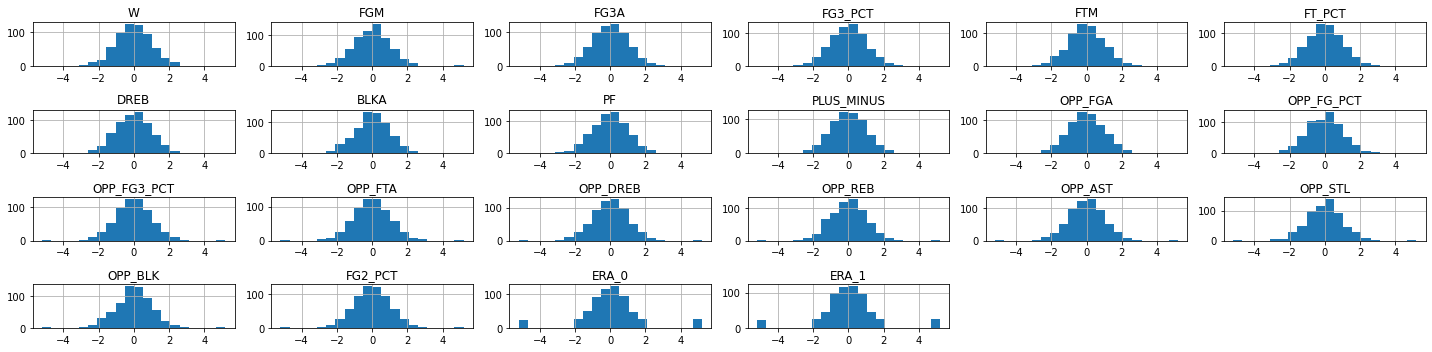

In [32]:
# plot distributions of each feature in X_train
fig, ax = plt.subplots(1,1)
plot_df = pd.DataFrame(data_preparation.fit_transform(season, season_label), 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 6) + 1, 6),
             ax = ax)
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# *add LDA to list of classifiers

# Shortlist promising models
- missing 
  - analyze most significant variables for each algorithm
  - analyze the type of errors the models make
    - what data would a human to use avoid these errors
  - perform a quick round of feature engineering and selection
  - shortlist models making different types of error

In [33]:
# create a list of models using standard hyperparameters to compare performance
cv = 10
dict_clf = {
    # need predict_proba() for all classifiers such that we can use some ensemble methods later
    # don't use class_weight = 'balanced' as that is equivalent to over-sampling which can emphasize existing bias (if any) in train set
    # think of alternative ways to deal with imbalance data
    # medium article: https://link.medium.com/wJZJhT2o3sb 
    "knn": KNeighborsClassifier(),
    "sgd": SGDClassifier(random_state=42, loss='modified_huber', penalty='elasticnet'), # train with loss = modified huber (quadratically smoothed SVM with gamma = 2)
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=1000),
    "svc": SVC(kernel='linear', random_state=42, probability=True), # SVC instead of LinearSVC for predict_proba()
    "svc_poly": SVC(kernel='poly', random_state=42, probability=True), # probability=True for predict_proba()
    "svc_rbf": SVC(kernel='rbf', random_state=42, probability=True), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "ada": GradientBoostingClassifier(random_state=42, loss='exponential'), # loss='exponential' for AdaBoost
    "xgb": XGBClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42)
}

In [ ]:
list_clf = []
auc_scores = []
list_fpr = []
list_tpr = []
list_thresholds = []

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(dict_clf.items()):
  clf = make_pipeline(data_preparation, item).fit(season, season_label)
  auc_score = cross_val_score(clf, season, season_label, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  # fpr, tpr, thresholds = roc_curve(season_label, y_scores)

  list_clf.append(key)
  # auc_scores.append(roc_auc_score(y_train, y_scores))
  auc_scores.append(auc_score)
  # list_fpr.append(fpr)
  # list_tpr.append(tpr)
  # list_thresholds.append(thresholds)
  

In [ ]:
# sort the models by AUC but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_auc = [np.mean(auc) for auc in auc_scores]
sd_auc = [np.std(auc) for auc in auc_scores]
print("Models sorted by cross validation AUC score")
for mean, sd, clf_name in sorted(zip(mean_auc, sd_auc, list_clf), reverse = True):
  print(f"CV AUC: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AUC score
CV AUC: AVG 0.9056 / SD 0.0870 / xgb
CV AUC: AVG 0.9001 / SD 0.0845 / forest
CV AUC: AVG 0.8930 / SD 0.1024 / xgbrf
CV AUC: AVG 0.8908 / SD 0.0711 / logistic
CV AUC: AVG 0.8888 / SD 0.0591 / svc
CV AUC: AVG 0.8668 / SD 0.0838 / sgd
CV AUC: AVG 0.8573 / SD 0.1653 / gb
CV AUC: AVG 0.8542 / SD 0.1592 / ada
CV AUC: AVG 0.8499 / SD 0.1101 / svc_poly
CV AUC: AVG 0.8464 / SD 0.0759 / svc_rbf
CV AUC: AVG 0.7409 / SD 0.1931 / knn
CV AUC: AVG 0.6441 / SD 0.2010 / tree


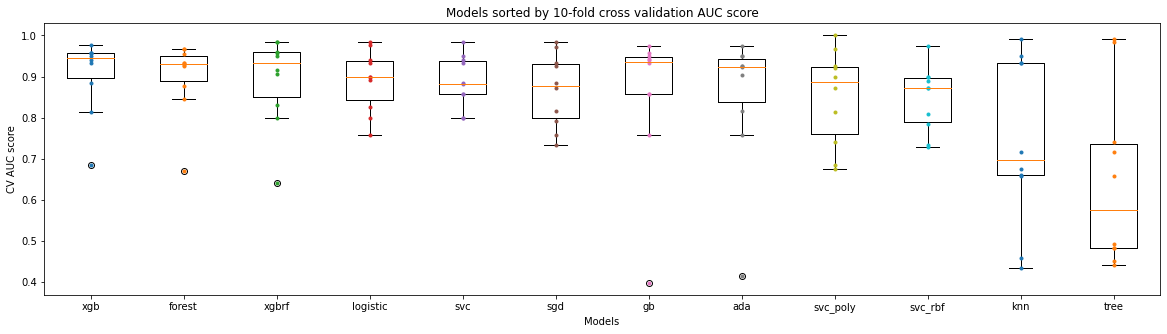

In [ ]:
# sort the models and plot the spread of CV AUC scores
mean_auc = [np.mean(auc) for auc in auc_scores]
sorted_auc = [i for _, i in sorted(zip(mean_auc, auc_scores), reverse = True)]
sorted_clf = [i for _, i in sorted(zip(mean_auc, list_clf), reverse = True)]
plt.boxplot(sorted_auc, labels=sorted_clf)
# add dots for CV AUC scores
for i, auc in enumerate(sorted_auc):
  plt.plot([i+1]*len(auc), auc, ".")
plt.title(f"Models sorted by {cv}-fold cross validation AUC score")
plt.xlabel("Models")
plt.ylabel("CV AUC score")
plt.show()

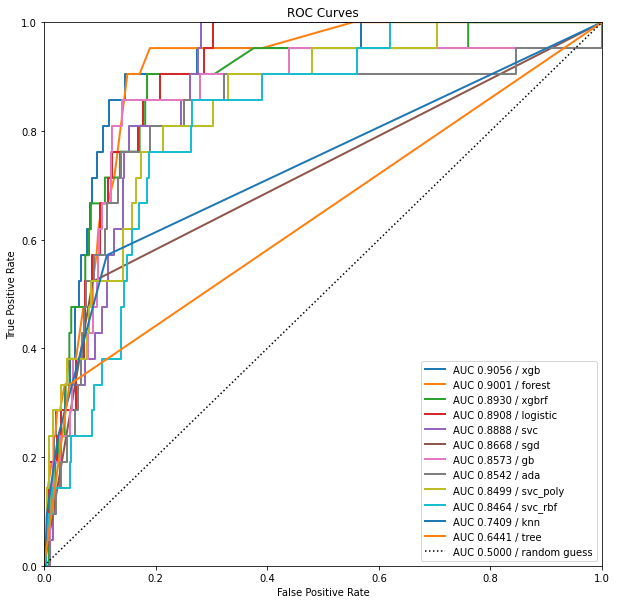

In [ ]:
figure(figsize=(10, 10))
for auc, fpr, tpr, clf_name in sorted(zip(mean_auc, list_fpr, list_tpr, list_clf), reverse = True):
  plt.plot(fpr, tpr, linewidth = 2, label = f"AUC {auc:0.4f} / {clf_name}")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# plt.plot(thresholds, precisions[:-1], 'b--', label = "Precision", linewidth = 2)
# plt.plot(thresholds, recalls[:-1], "g--", label = "Recall", linewidth = 2)
# plt.vlines(0, 0, 1.0, "k", "dotted", label = "Threshold")
# plt.legend()
# plt.show()

In [ ]:

# fpr, tpr, thresholds = roc_curve(y_train, y_scores)
# plt.plot(fpr, tpr, linewidth = 2, label = f"ROC Curve (AUC = {roc_auc_score(y_train, y_scores):0.4f})")
# plt.plot([0,1], [0,1], 'k:', label = "Random guess (AUC = 0.5)")
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.legend()
# plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [ ]:
# print top models to tune
top = 6
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

xgb XGBClassifier(random_state=42)
forest RandomForestClassifier(random_state=42)
xgbrf XGBRFClassifier(random_state=42)
logistic LogisticRegression(l1_ratio=0.15, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
svc SVC(kernel='linear', probability=True, random_state=42)
sgd SGDClassifier(loss='modified_huber', penalty='elasticnet', random_state=42)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

In [ ]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
for i in range(1,100000,10000):
  i = i/10000
  full_pipeline = make_pipeline( 
      data_preparation,
      SGDClassifier(random_state=42, penalty='elasticnet', loss='modified_huber', alpha=i)
  )

  full_pipeline.fit(season, season_label)
  cv_score = cross_val_score(full_pipeline, season, season_label, cv = 5, scoring='roc_auc')
  print(i, cv_score)
  print(np.mean(cv_score), np.std(cv_score))
  # print(full_pipeline.get_params().keys())
  # plt.hist([np.log2(x) for x in loguniform(a=2**-2, b=2**2).rvs(size=10**6)])

0.0001 [0.96302521 0.875      0.84243697 0.92226891 0.91386555]
0.9033193277310924 0.04133702193077993
1.0001 [0.98319328 0.93333333 0.86344538 0.97478992 0.93697479]
0.9383473389355743 0.04237109269711552
2.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
3.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
4.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
5.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
6.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
7.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
8.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0
9.0001 [0.5 0.5 0.5 0.5 0.5]
0.5 0.0


In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "xgb": XGBClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42),
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=1000),
    "svc": SVC(kernel='linear', probability=True, max_iter=10**5, random_state=42),
    "sgd": SGDClassifier(random_state=42, penalty='elasticnet', loss='modified_huber')
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__gamma": randint(low = 0, high = 10),
        "xgb__reg_alpha": randint(low = 0, high = 10),
        "xgb__reg_gamma": randint(low = 0, high = 10),
        "xgb__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgb__max_depth": randint(low = 1, high = 5),
        "xgb__min_child_weight": randint(low = 1, high = 30),
    },

    "xgbrf": {
        "xgbrf__gamma": randint(low = 0, high = 10),
        "xgbrf__reg_alpha": randint(low = 0, high = 10),
        "xgbrf__reg_gamma": randint(low = 0, high = 10),
        "xgbrf__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgbrf__max_depth": randint(low = 1, high = 5),
        "xgbrf__min_child_weight": randint(low = 1, high = 30),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 3, high = 5),
        "forest__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "forest__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "logistic": {
        "logistic__C": loguniform(a = 10**-1, b = 10**1),
        "logistic__l1_ratio": uniform(loc = 0, scale = 1),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc": {
        "svc__C": loguniform(a = 10**-2, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    "sgd": {
        "sgd__l1_ratio": uniform(loc = 0, scale = 1),
        "sgd__alpha": loguniform(a = 10**-4, b = 10**0)
    }
    
}

In [ ]:
random_clfs = []

for clf_name, clf in tqdm(shortlisted_clfs.items()):
  
  full_pipeline = Pipeline([ 
    ("preparation", data_preparation),
    (clf_name, clf)
  ])

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune C for inverse of regularization strength in lasso penalty for feature selection in data_prepartion pipeline
  param_grid["preparation__selector__estimator__C"] = loguniform(a = 10**0, b = 10**1)
  
  print(param_grid)

  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 10, 
                                    scoring = "roc_auc",
                                    random_state = 42,
                                    n_jobs = -1,
                                    error_score = 'raise')

  random_search.fit(season, season_label)
  random_clfs.append(random_search)

  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  # print(pd.DataFrame(random_search.cv_results_))

  0%|          | 0/6 [00:00<?, ?it/s]

xgb
XGBClassifier(random_state=42)
{'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068403e90>, 'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068403fd0>, 'xgb__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068403990>, 'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0684cfc90>, 'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0684cfe50>, 'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0684cf110>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0684cf1d0>}


 17%|█▋        | 1/6 [01:26<07:13, 86.74s/it]


best_score: 0.9104519774011297
best_params: {'preparation__selector__estimator__C': 2.412470387944658, 'xgb__gamma': 3, 'xgb__learning_rate': 0.6024145688620425, 'xgb__max_depth': 3, 'xgb__min_child_weight': 5, 'xgb__reg_alpha': 2, 'xgb__reg_gamma': 6}
forest
RandomForestClassifier(random_state=42)
{'forest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06845fc90>, 'forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068474dd0>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068474150>}


 33%|███▎      | 2/6 [03:00<06:03, 90.83s/it]


best_score: 0.9241949152542371
best_params: {'forest__max_depth': 3, 'forest__min_samples_split': 0.2999304858576277, 'preparation__selector__estimator__C': 1.1134370364229915}
xgbrf
XGBRFClassifier(random_state=42)
{'xgbrf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06867fdd0>, 'xgbrf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06867f610>, 'xgbrf__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06aabbd50>, 'xgbrf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0683ccd90>, 'xgbrf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb05f558210>, 'xgbrf__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb05f558e50>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068474690>}


 50%|█████     | 3/6 [04:17<04:14, 84.72s/it]


best_score: 0.8785946327683616
best_params: {'preparation__selector__estimator__C': 2.412470387944658, 'xgbrf__gamma': 3, 'xgbrf__learning_rate': 0.6024145688620425, 'xgbrf__max_depth': 3, 'xgbrf__min_child_weight': 5, 'xgbrf__reg_alpha': 2, 'xgbrf__reg_gamma': 6}
logistic
LogisticRegression(l1_ratio=0.15, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
{'logistic__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06a254750>, 'logistic__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0687f5750>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0686d1990>}


 67%|██████▋   | 4/6 [05:47<02:53, 86.57s/it]


best_score: 0.9241807909604519
best_params: {'logistic__C': 0.19010245319870353, 'logistic__l1_ratio': 0.29214464853521815, 'preparation__selector__estimator__C': 2.324672848950434}
svc
SVC(kernel='linear', max_iter=100000, probability=True, random_state=42)
{'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06a16ded0>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06b4a6ed0>}


 83%|████████▎ | 5/6 [07:08<01:24, 84.66s/it]


best_score: 0.908361581920904
best_params: {'preparation__selector__estimator__C': 1.432249371823025, 'svc__C': 0.029375384576328285}
sgd
SGDClassifier(loss='modified_huber', penalty='elasticnet', random_state=42)
{'sgd__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb06840d1d0>, 'sgd__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb0684038d0>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb068639950>}


100%|██████████| 6/6 [08:27<00:00, 84.57s/it]


best_score: 0.9419491525423729
best_params: {'preparation__selector__estimator__C': 2.858051065806936, 'sgd__alpha': 0.13826232179369854, 'sgd__l1_ratio': 0.19967378215835974}


In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for i, random_clf in enumerate(random_clfs):
  print(f'model{i} {random_clf.best_estimator_.steps[1][0]} dumped')
  dump(random_clf, f'model{i}_tuned.joblib') 

model0 xgb dumped
model1 forest dumped
model2 xgbrf dumped
model3 logistic dumped
model4 svc dumped
model5 sgd dumped


## Check model performance after hyperparameter tuning

In [34]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [35]:
tuned_models = {}
for file in [x for x in os.listdir() if '_tuned.joblib' in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[1][0]] = model
  print(model.best_estimator_.steps[1][0], "loaded")

sgd loaded
xgb loaded
svc loaded
forest loaded
logistic loaded
xgbrf loaded


In [36]:
# pull the CV AUC results from RandomizedSearchCV
tuned_auc = []
for clf_name, model in tuned_models.items():
  # tuned_auc.append(cross_val_score(model.best_estimator_, season, season_label, cv = 10, scoring='roc_auc'))
  cv_auc_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w_test_score', x) is not None]
  tuned_auc.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_auc_colindex].values)

In [37]:
# sort the models and plot the spread of CV AUC scores
mean_tuned_auc = [np.mean(auc) for auc in tuned_auc]
sorted_tuned_auc = [i for _, i in sorted(zip(mean_tuned_auc, tuned_auc), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_auc, tuned_models.keys()), reverse = True)]

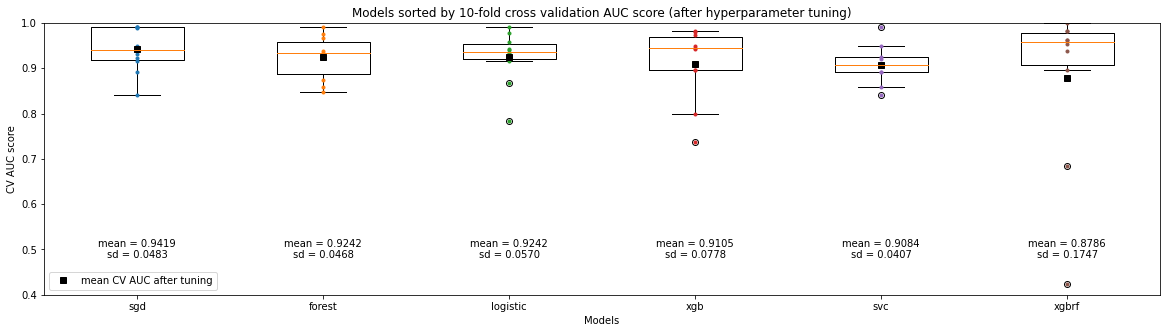

In [73]:
plt.boxplot(sorted_tuned_auc, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, auc in enumerate(sorted_tuned_auc):
  plt.plot([i+1]*len(auc), auc, ".")
  plt.annotate(f"mean = {np.mean(auc):0.4f}\nsd = {np.std(auc):0.4f}",(i+1, 0.5), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], sorted(mean_tuned_auc, reverse=True), 
         "ks", label = 'mean CV AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], [mean_auc[list_clf.index(x)] for x in sorted_tuned_clf], 
#          "k^", label = 'mean CV AUC before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0.4,1)
plt.ylabel("CV AUC score")
plt.show()

# Ensemble methods

In [39]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [70]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in tuned_models:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[1][1]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 5, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AUC = 0.5000, std AUC = 0.0000, Adaboost sgd
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgb
mean AUC = 0.9116, std AUC = 0.0360, Adaboost svc
mean AUC = 0.9008, std AUC = 0.0556, Adaboost forest
mean AUC = 0.5000, std AUC = 0.0000, Adaboost logistic
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgbrf
mean AUC = 0.9325, std AUC = 0.0481, Bagging sgd
mean AUC = 0.9251, std AUC = 0.0388, Bagging xgb
mean AUC = 0.8917, std AUC = 0.0410, Bagging svc
mean AUC = 0.9068, std AUC = 0.0514, Bagging forest


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


mean AUC = 0.9201, std AUC = 0.0557, Bagging logistic
mean AUC = 0.9119, std AUC = 0.0733, Bagging xgbrf


In [66]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(key, item.best_estimator_.steps[1][1]) for key, item in tuned_models.items()][:(i+1)]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 5, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {[key for key in tuned_models][:(i+1)]}")

mean AUC = 0.9168, std AUC = 0.0653, Voting ['sgd', 'xgb']
mean AUC = 0.9208, std AUC = 0.0384, Voting ['sgd', 'xgb', 'svc']
mean AUC = 0.9235, std AUC = 0.0360, Voting ['sgd', 'xgb', 'svc', 'forest']
mean AUC = 0.9253, std AUC = 0.0394, Voting ['sgd', 'xgb', 'svc', 'forest', 'logistic']
mean AUC = 0.9263, std AUC = 0.0390, Voting ['sgd', 'xgb', 'svc', 'forest', 'logistic', 'xgbrf']
mean AUC = 0.7868, std AUC = 0.0935, Stacking ['sgd', 'xgb']
mean AUC = 0.8004, std AUC = 0.1017, Stacking ['sgd', 'xgb', 'svc']
mean AUC = 0.8207, std AUC = 0.1487, Stacking ['sgd', 'xgb', 'svc', 'forest']
mean AUC = 0.8420, std AUC = 0.1203, Stacking ['sgd', 'xgb', 'svc', 'forest', 'logistic']
mean AUC = 0.8596, std AUC = 0.0836, Stacking ['sgd', 'xgb', 'svc', 'forest', 'logistic', 'xgbrf']


# Test set evaluation
- ROC curve
- Confusion matrix
- precision and recall curve
- lift and gain chart